In [18]:
import h5py
import torch
import logging
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from lavis.models.clip_models.loss import ClipLoss
from torch.utils.data import DataLoader, Dataset
import random
import itertools
from sklearn.metrics import accuracy_score

from models.mlp import MLP,ProjectLayer,Direct
from datasets import SingleEEGDataset

from sklearn.decomposition import PCA
import umap

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

def set_logging(file_path):
    logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(message)s',filename=file_path,force=True)

    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    console_handler.setFormatter(formatter)
    logging.getLogger('').addHandler(console_handler)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
set_seed(0)
selected_ch = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3',
                                        'F1', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 
                                        'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T7', 'C5', 'C3', 'C1',
                                        'Cz', 'C2', 'C4', 'C6', 'T8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 
                                        'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P7', 'P5', 'P3', 'P1',
                                        'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8',
                                        'O1', 'Oz', 'O2']
config = {
    "data_dir": "/root/workspace/wht/multimodal_brain/datasets/things-eeg-small/Preprocessed_data_250Hz",
    "exp_root":'./exp',
    "name": 'plot_eeg_representation',
    "lr": 1e-4,
    "epochs": 100,
    "batch_size": 1024,
    "logger": True,
    "insubject": True,
    "subject":'sub-08', # ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
    "selected_ch": selected_ch,
    "eeg_model": {'name':'MLP',"args":{'input_dim':len(selected_ch)*250,'output_dim':1024,'hiden_dims':[]}},
    "img_model": {'name':'Direct',"args":{}},  # {'name':'ProjectLayer', "args":{'embedding_dim':1024, 'proj_dim':1024}},
    "text_model": {'name':'Direct',"args":{}},  # {'name':'ProjectLayer', "args":{'embedding_dim':1024, 'proj_dim':1024}},
    "n_way":4
}

config['exp_dir'] = os.path.join(config['exp_root'],config['name'])
os.makedirs(config['exp_dir'],exist_ok=True)
set_logging(os.path.join(config['exp_dir'],'exp.LOG'))
logging.info(f"-------------------------START-------------------------")
logging.info(f"CONFIG: {config}")

data_dir = config['data_dir']
subject = config['subject']
logging.info(f"Start training on {subject}")
eeg_model = globals()[config['eeg_model']['name']](**config['eeg_model']['args'])
ckpt = torch.load('/root/workspace/wht/multimodal_brain/src/exp/train_align_CLIP/ckpt.pth')
eeg_model.load_state_dict(ckpt['eeg'])
eeg_model.to(device)

    
test_dataset = SingleEEGDataset(data_dir, subject=subject, mode='test',selected_ch=config['selected_ch'],average=False)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False, drop_last=False,num_workers=4)
    

2024-05-22 01:45:56,801 - -------------------------START-------------------------
2024-05-22 01:45:56,802 - CONFIG: {'data_dir': '/root/workspace/wht/multimodal_brain/datasets/things-eeg-small/Preprocessed_data_250Hz', 'exp_root': './exp', 'name': 'plot_eeg_representation', 'lr': 0.0001, 'epochs': 100, 'batch_size': 1024, 'logger': True, 'insubject': True, 'subject': 'sub-08', 'selected_ch': ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2'], 'eeg_model': {'name': 'MLP', 'args': {'input_dim': 15750, 'output_dim': 1024, 'hiden_dims': []}}, 'img_model': {'name': 'Direct', 'args': {}}, 'text_model': {'name': 'Direct', 'args': {}}, 

----load test data----


2024-05-22 01:46:32,332 - eeg: torch.Size([16000, 63, 250])
2024-05-22 01:46:32,335 - session: (16000,)
2024-05-22 01:46:32,336 - img: (16000,)
2024-05-22 01:46:32,337 - text: (16000,)
2024-05-22 01:46:32,337 - class_label: (16000,)


In [10]:
eeg_model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=15750, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [15]:
all_eeg_features = []
session_list = []
label_list = []
eeg_model.eval()

for i,sample in enumerate(test_loader):
    eeg, label, img, img_features,text, text_features ,session = sample
    eeg = eeg.to(device)
    eeg_features = eeg_model(eeg).detach().cpu().numpy()
    
    all_eeg_features.append(eeg_features)
    session_list.append(session)
    label_list.append(label)
    
all_eeg_features = np.concatenate(all_eeg_features)
session_list = np.concatenate(session_list)
label_list = np.concatenate(label_list)
print(all_eeg_features.shape)
print(session_list.shape)
print(label_list.shape)

(16000, 1024)
(16000,)
(16000,)


In [20]:
k = 4
n_components = 50
n_neighbors = 50
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(all_eeg_features)
reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=0)
embedding_2d = reducer.fit_transform(data_pca)

kmeans = KMeans(n_clusters=k)
knn_prediction = kmeans.fit_predict(data_pca)

cluster_centers = kmeans.cluster_centers_


2024-05-22 01:56:16,484 - /root/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



In [24]:
label_list

array([  0,   0,   0, ..., 199, 199, 199])

4000
4000
4000
4000


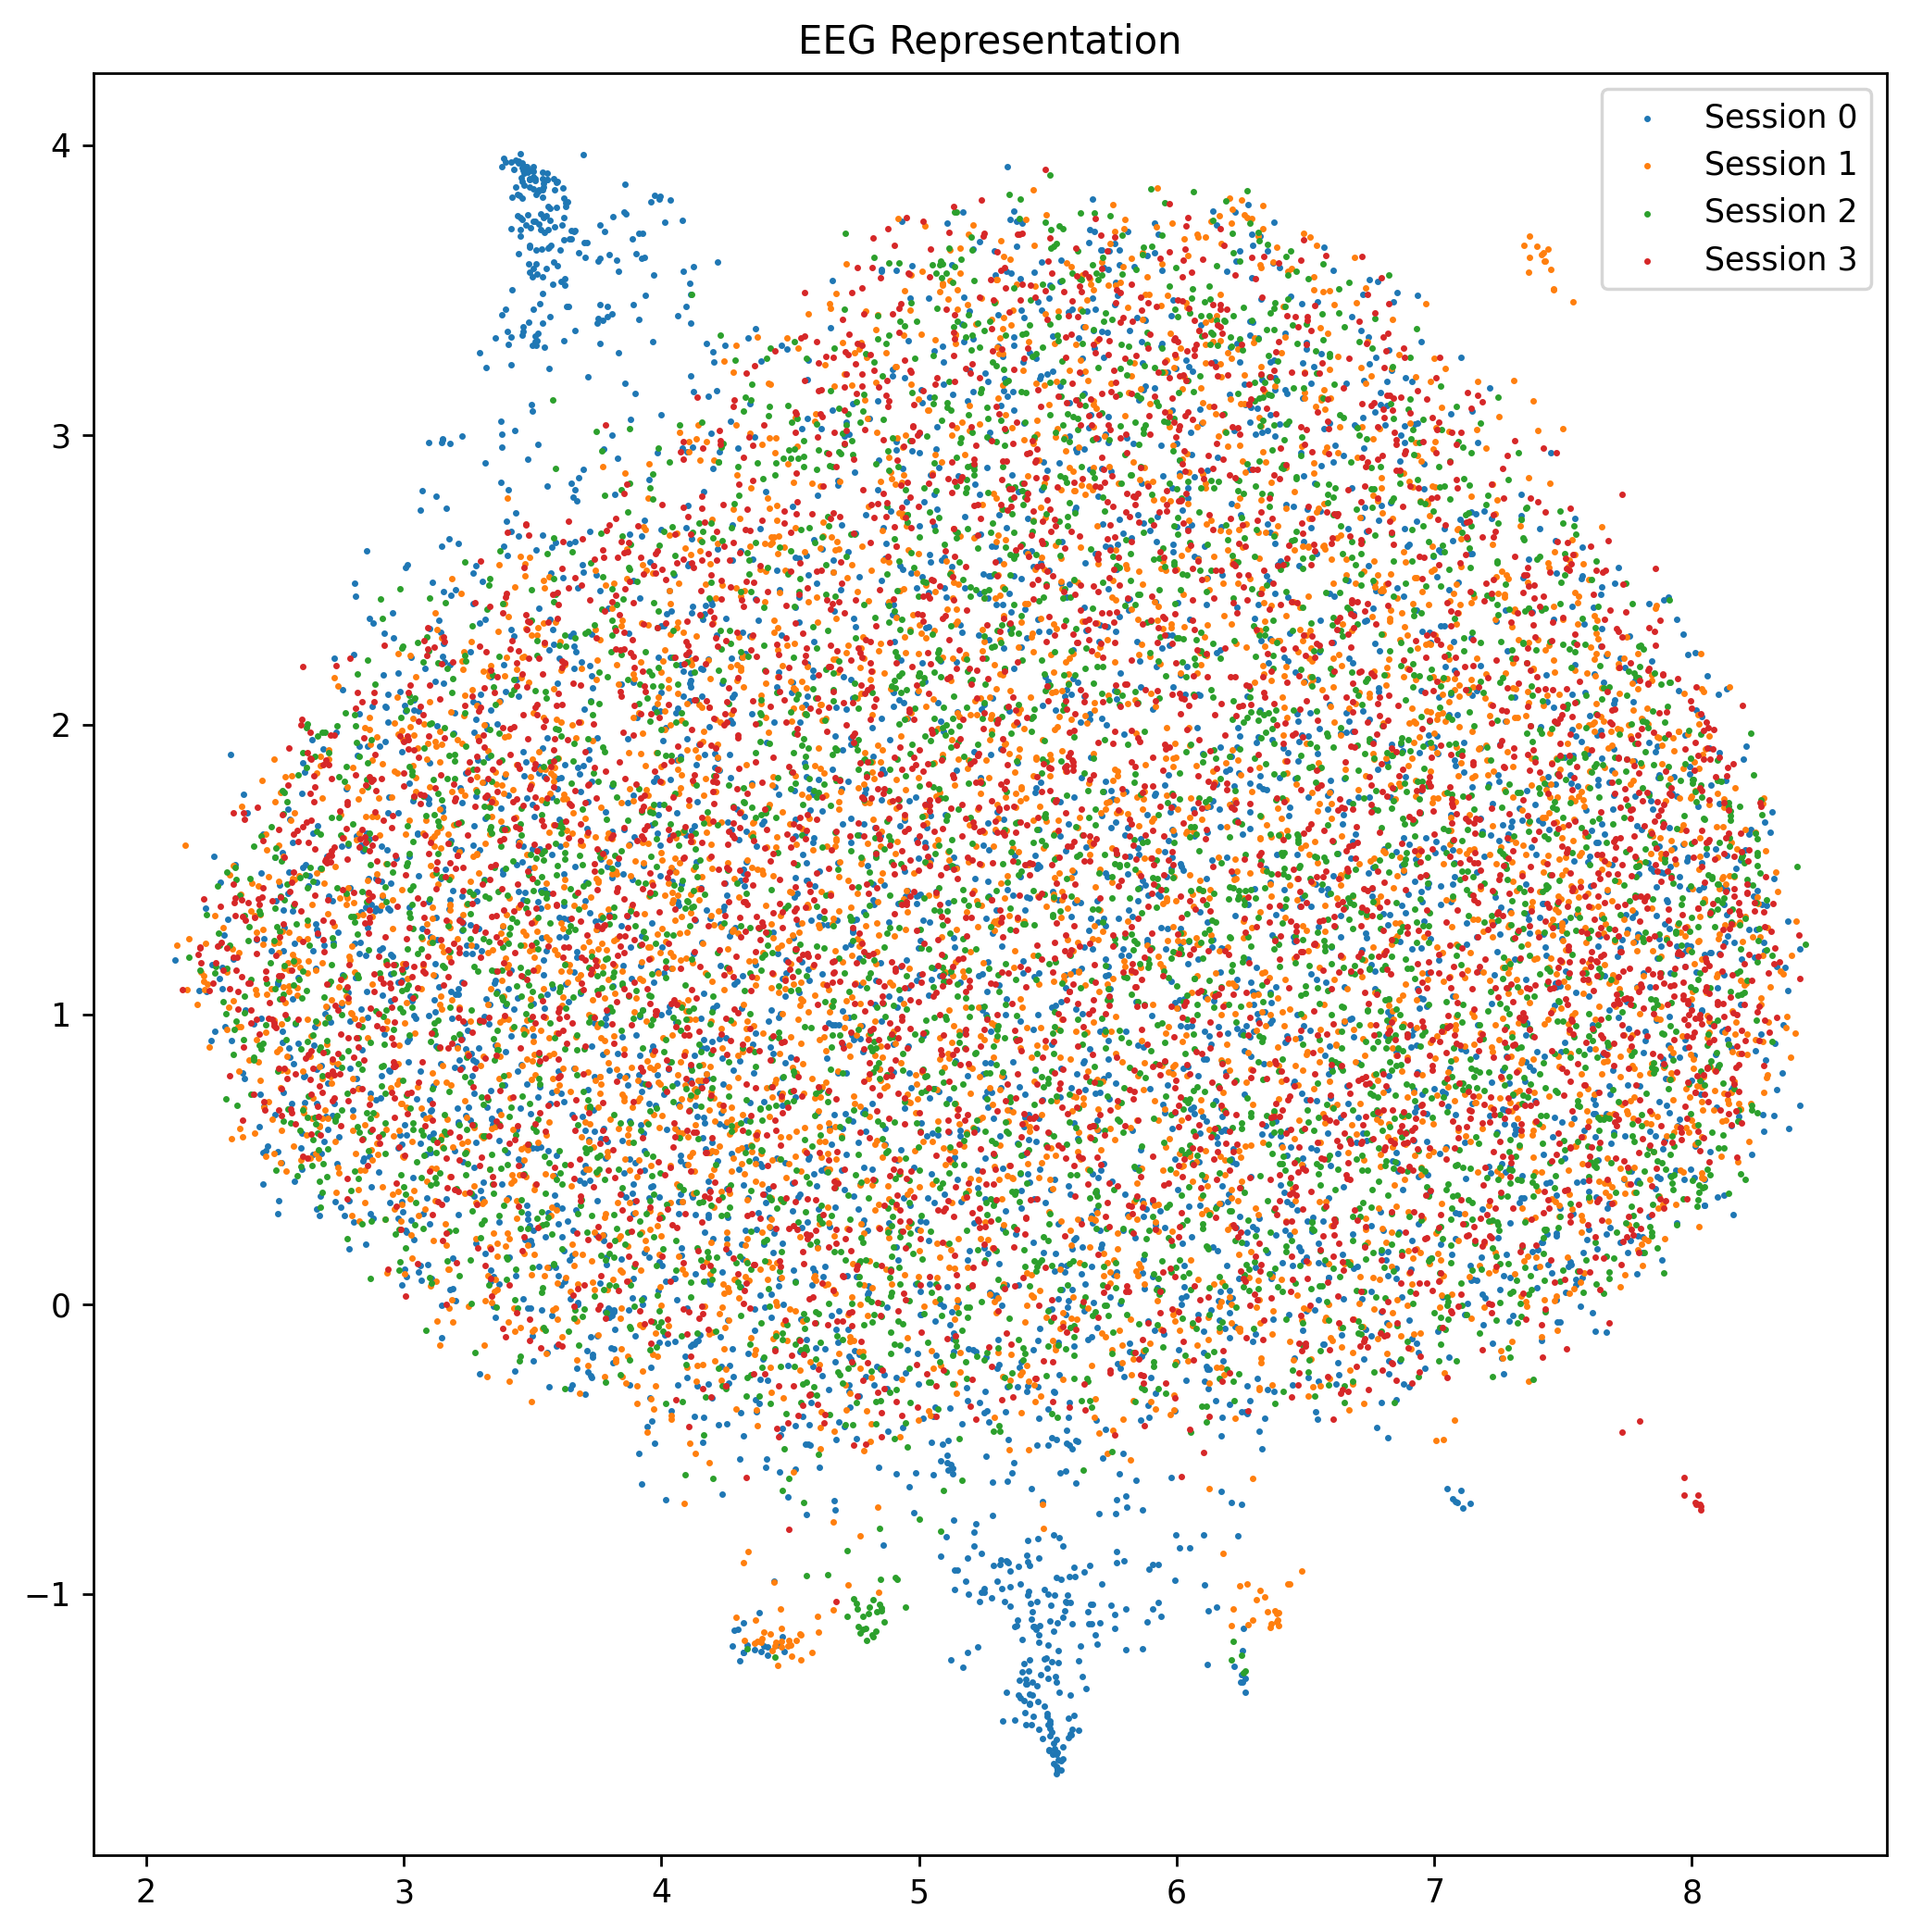

In [37]:
plt.figure(figsize=(10, 10),dpi=250) 
label=[0,1,2,3,4]
label = [i for i in range(200)]

plt.title('EEG Representation')

for session in list(set(session_list)):
        indices = [i for i, x in enumerate(session_list) if x == session and label_list[i] in label]
        print(len(indices)) #20
        plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1],label=f'Session {session}',s=1)  
plt.legend()
plt.savefig('./results/eeg_representation.png', bbox_inches='tight')